In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.isnull().sum()
raw_df.dropna(inplace=True)
raw_df.head()

label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  
1  The blazers and Mavericks (The wests 5 and 6 s...  
2                            They're favored to win.  
3                         deadass don't kill my buzz  
4  Yep can confirm I saw the tool they use for th...

In [36]:
# Convert 'created_utc' to datetime to extract the year
raw_df['created_utc'] = pd.to_datetime(raw_df['created_utc'])
raw_df['year'] = raw_df['created_utc'].dt.year

Target_Year = 2016

# filter out the sarcastic comments
sarcastic_comments = raw_df[raw_df['label'] == 1]
sarcastic_comments_year = sarcastic_comments[sarcastic_comments['year'] == Target_Year]

# filter out the non-sarcastic comments
n_sarcastic_comments = raw_df[raw_df['label'] == 0]

# Topic Modelling

In [37]:
# Function to preprocess text and return words as a comma-separated string
def preprocess_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()
    # Step 2: Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Step 3: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Step 4: Remove stopwords (common words like "the," "is," etc.)
    text = " ".join([word for word in nltk.word_tokenize(text) if word.lower() not in stopwords.words('english')])
    # Step 5: Remove short words (length < 3)
    text = " ".join([word for word in nltk.word_tokenize(text) if len(word) >= 3])
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each word in the text
    text = " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])
    return text

In [38]:
sarcastic_processed = []


for text in tqdm(sarcastic_comments_year["comment"]):
    # Step 6: Preprocess the text
    preprocessed_text = preprocess_text(text)
    # Step 7: Lemmatize the preprocessed text
    preprocessed_text = lemmatize_text(preprocessed_text)
    # Append the processed text to the list
    sarcastic_processed.append(preprocessed_text)


100%|██████████| 222781/222781 [05:00<00:00, 740.95it/s]


In [39]:
sarcastic_processed[:10]

['theyll review',
 'wow totally unreasonable assume agency covered bush war crime muh republican party would partisan fuck',
 'melania said way could happened didnt know woman',
 'cant wait potus start twitter war morning joe',
 'got love teacher give exam day halloween',
 'hoiberg said great player dwight',
 'never realized easy every lonely person earth never thought',
 'exactly reason whatsoever',
 'hank would great time legend tomorrow',
 'remember reading story news riot police marching volvo head office truncheon beating designer invented seatbelt']

In [40]:
# vectorize the parent_comment and comment columns
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vec = vectorizer.fit_transform(sarcastic_processed)

In [51]:
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 8
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=42, max_iter=1)

In [52]:
lda_top = lda_model.fit_transform(vec)

In [53]:
print(lda_model.components_)

[[0.125      0.12514552 0.125      ... 0.12501459 0.1255506  0.12723907]
 [0.125      0.12688898 0.125      ... 0.1296726  1.20309765 0.12726329]
 [0.125      0.12513836 0.12500181 ... 0.12501851 0.12570765 0.12793343]
 ...
 [0.12500117 0.12530008 0.125      ... 0.12501526 0.12557226 0.12734904]
 [0.125      7.57792478 0.1250099  ... 0.12501631 0.12561814 7.52034784]
 [0.12503183 0.12554624 0.125      ... 0.16629571 1.74599057 0.1273665 ]]


In [54]:
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
racist right people need dont yeah youre trump would black 
Topic 1: 
hey cant really good nice much woman put tell thing 
Topic 2: 
forgot add got wonder dare think forgot watch playing must full 
Topic 3: 
yeah fuck sorry bernie least yes lol confirmed worked big 
Topic 4: 
obviously white thanks mean people fault idea gon show fucking 
Topic 5: 
wait never year one yeah totally post see everything cant 
Topic 6: 
dropped think dont look god get try please look like funny 

Topic 7: 
like sure sound well know make thats man wow good 


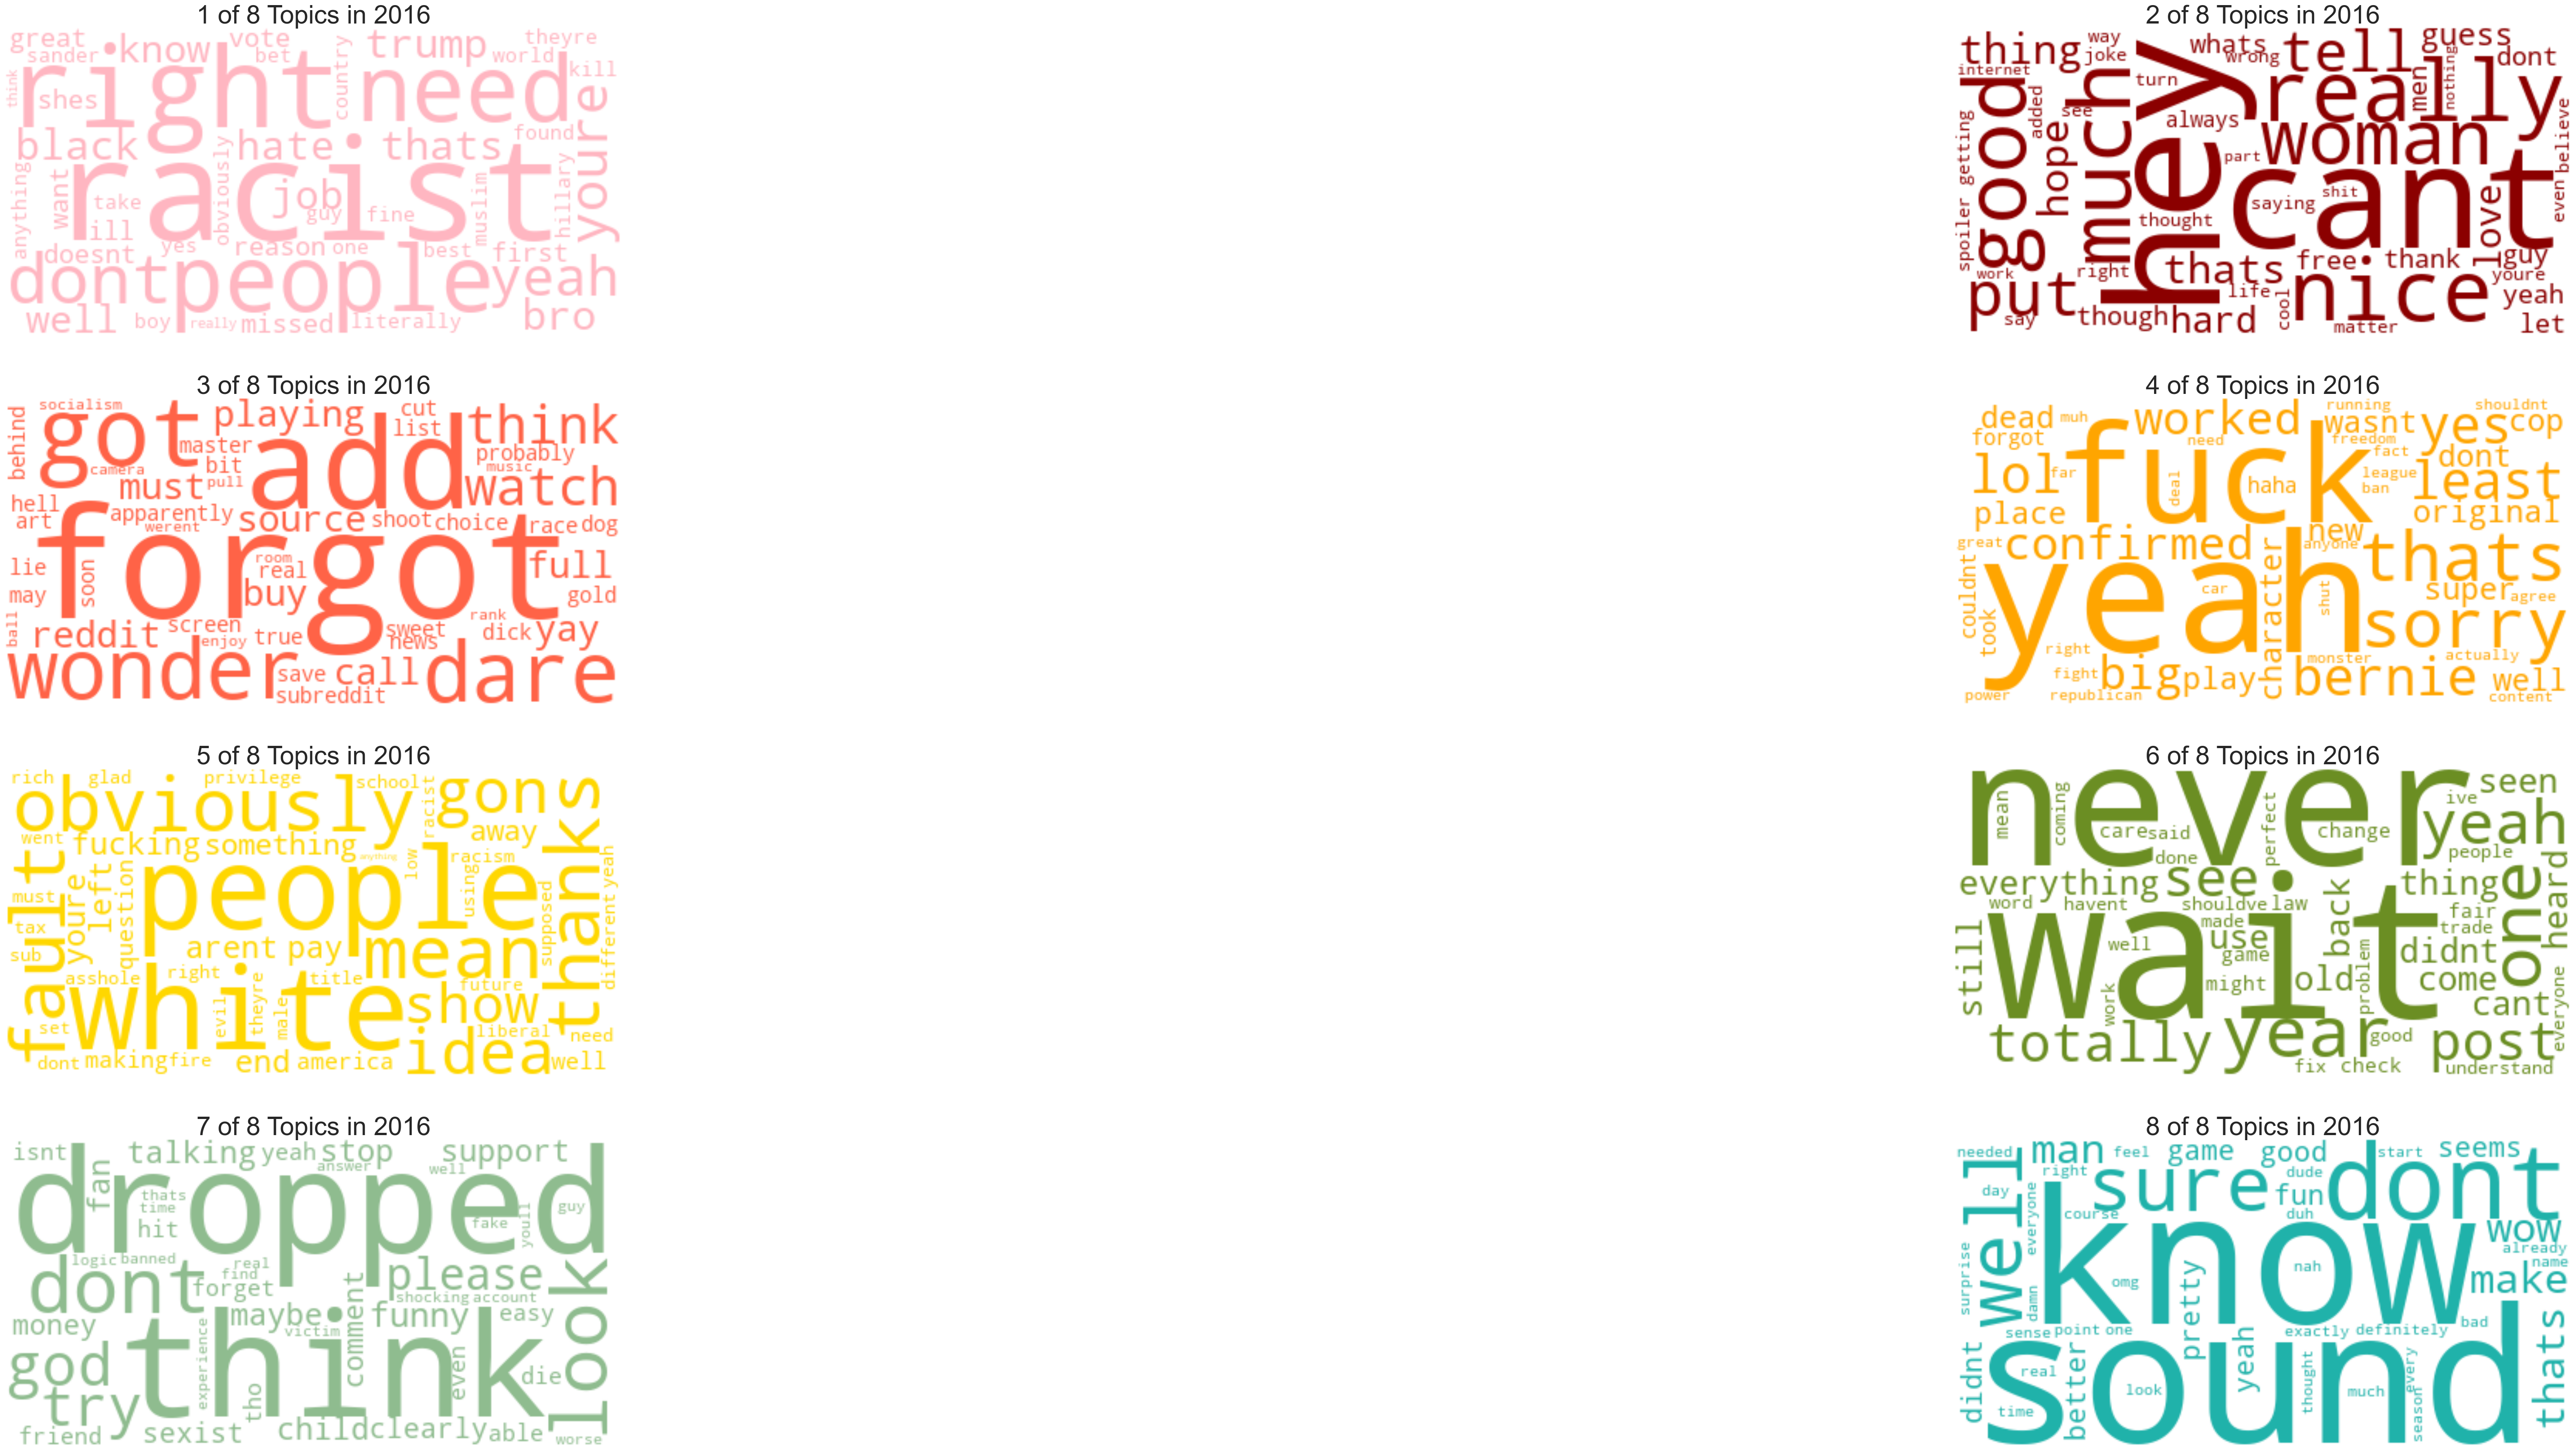

In [61]:
from wordcloud import WordCloud

topic_colors = ['lightpink', 'darkred', 'tomato', 'orange', 'gold', 'olivedrab', 'darkseagreen', 'lightseagreen', 'lightskyblue', 'steelblue']

topic_wordclouds = []

for i in range(num_topics):
    imp_words_topic=""
    comp=lda_model.components_[i]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
      imp_words_topic=imp_words_topic+" "+word[0]
    
    # Generate word cloud with the topic's color
    wordcloud = WordCloud(width=400, height=200, background_color='white', color_func=lambda *args, **kwargs: topic_colors[i]).generate(imp_words_topic)
    topic_wordclouds.append(wordcloud)

plt.figure(figsize=(100, 40))
for i, wordcloud in enumerate(topic_wordclouds):
    plt.subplot(4, 2, i+1) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('{} of 8 Topics in 2016'.format(i+1),fontsize=40)
    plt.axis("off")

plt.show()

In [27]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
dash = pyLDAvis.lda_model.prepare(lda_model, vec, vectorizer, mds='tsne')
dash

ModuleNotFoundError: No module named 'pyLDAvis'

In [ ]:
pyLDAvis.save_html(dash, 'lda_visualization.html')

## How to interpret this graph?
- Topics on the left while their respective keywords are on the right.
- Larger topics are more frequent and closer the topics, mor the similarity.
- Selection of keywords is based on their frequency and discriminancy.


# Sentiment Analysis

In [39]:
# Calculate sentiment score using BERT
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.eval()

def calculate_sentiment_labels(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1) 
    return predictions.numpy()



c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lenovo\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

In [40]:
sub = sarcastic_comments[:1000]
sub.head()

label                                            comment         author  \
33      1                But they'll have all those reviews!  RoguishPoppet   
44      1  wow it is totally unreasonable to assume that ...       pb2crazy   
45      1  Ho ho ho... But Melania said that there is no ...       pb2crazy   
66      1  I can't wait until @potus starts a twitter war...      kitduncan   
69      1  gotta love the teachers who give exams on the ...          DEP61   

         subreddit  score  ups  downs     date          created_utc  \
33  ProductTesting      0   -1     -1  2016-11  2016-11-01 02:04:59   
44        politics      2   -1     -1  2016-11  2016-11-01 02:42:11   
45        politics      8   -1     -1  2016-10  2016-10-18 16:20:53   
66        politics      3   -1     -1  2016-11  2016-11-01 03:22:33   
69     CFBOffTopic      3   -1     -1  2016-11  2016-11-01 03:30:11   

                                       parent_comment  
33  The dumb thing is, they are risking their sell...  
44  Clinton campaign accuses FBI of 'blatant doubl...  
45  Anyone else think that it was interesting the ...  
66  Here's what happens when Obama gives up his Tw...  
69  Monday night Drinking thread Brought to You by...